In [1]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import copy

# Import network objects
from PolicyNetwork import PolicyNetwork
from ValueNetwork import ValueNetwork

In [13]:
# Train using gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_of_sensors = 50
input_size = 4*num_of_sensors+2

accel_policy = PolicyNetwork(input_size)
turn_policy = PolicyNetwork(input_size)
value_function = ValueNetwork(input_size)

# Network locations
acceleration_path = 'models/acceleration_network.pth'
turn_path = 'models/turn_network.pth'
value_path = 'models/value_network.pth'

# Load networks
accel_policy.load_state_dict(torch.load(acceleration_path))
turn_policy.load_state_dict(torch.load(turn_path))
value_function.load_state_dict(torch.load(value_path))

accel_policy.to(device)
turn_policy.to(device)
value_function.to(device)


ValueNetwork(
  (layers): Sequential(
    (0): Linear(in_features=202, out_features=202, bias=True)
    (1): Tanh()
    (2): LayerNorm((202,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=202, out_features=202, bias=True)
    (5): Tanh()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=202, out_features=1, bias=True)
  )
)

In [8]:
# Load and read trajectory csv file
trajectories_file = 'data/trajectories.csv'
trajectories = pd.read_csv(trajectories_file)

# Store trajectory values into state, action, reward vectors
states = trajectories.iloc[:, 1:-3].values
actions = trajectories.iloc[:, -3:-1].values
rewards = trajectories.iloc[:, -1:].values

# Calculate reward-to-go
reward_to_go = np.array([[reward[0]] for reward in rewards])
for i in range(len(reward_to_go)-2,-1,-1): reward_to_go[i][0] += reward_to_go[i][0]

# Convert to tensor
states_tensor = torch.tensor(states).float()
actions_tensor = torch.tensor(actions).float()
reward_to_go_tensor = torch.tensor(reward_to_go).float()

#Store in dataset
dataset = TensorDataset(states_tensor, reward_to_go_tensor, actions_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Train value function

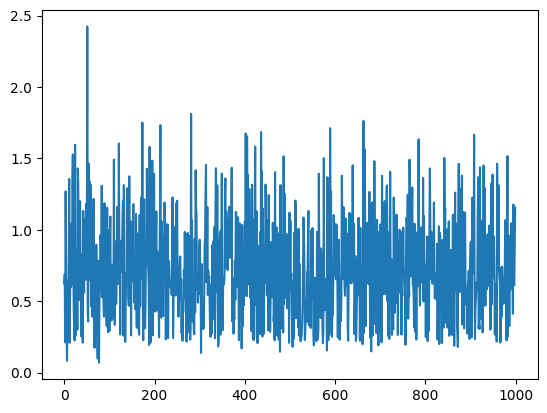

In [9]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(value_function.parameters(), lr=0.0001, weight_decay=0.0001)

losses = []
epochs = 1000
for epoch in range(epochs):
    for inputs_batch, outputs_batch, _ in dataloader:
        # Move batches to GPU
        inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = value_function(inputs_batch)

        # Compute the loss
        loss = loss_function(predictions, outputs_batch)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

    losses.append(loss.item())
    
plt.plot(losses)
plt.show()

Train Policy Networks

C:\Users\mattd\AppData\Local\Temp\ipykernel_240288\1847906945.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accelerations = torch.tensor(actions_batch[:,0])
C:\Users\mattd\AppData\Local\Temp\ipykernel_240288\1847906945.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  turns = torch.tensor(actions_batch[:,1])


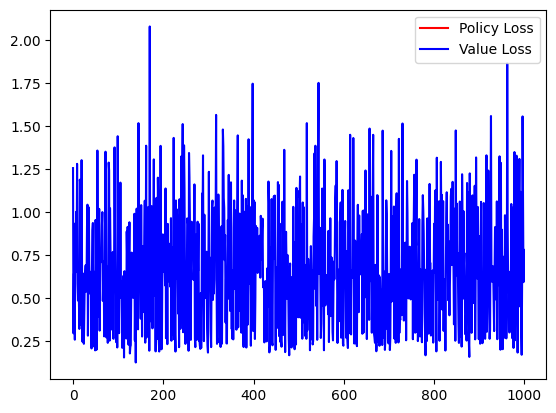

In [18]:
policy_optimizer = optim.Adam(list(accel_policy.parameters())+list(turn_policy.parameters()),lr=0.0001)
value_optimizer = optim.Adam(value_function.parameters(),lr=0.0001)

epsilon = 0.2 # Clipping factor

policy_losses = []
value_losses = []

epochs = 1000

for epoch in range(epochs):
    for inputs_batch, outputs_batch, actions_batch in dataloader:
        # Move batches to GPU
        inputs_batch, outputs_batch, actions_batch = inputs_batch.to(device), outputs_batch.to(device), actions_batch.to(device)

        # Clone current policy and value networks
        accel_policy_old = copy.deepcopy(accel_policy)
        turn_policy_old = copy.deepcopy(turn_policy)
        value_function_old = copy.deepcopy(value_function)

        values = value_function(inputs_batch)

        # Freeze clone networks
        for param in accel_policy_old.parameters(): param.requires_grad = False
        for param in turn_policy_old.parameters(): param.requires_grad = False
        for param in value_function_old.parameters(): param.requires_grad = False

        # Calculate advantages
        advantages = outputs_batch.cpu() - value_function_old(inputs_batch).cpu().numpy()
        advantages = advantages.to(device)

        # Get old policy distribution from policy networks
        accel_mean_old, accel_stdev_old = accel_policy_old(inputs_batch)[:,0],accel_policy_old(inputs_batch)[:,1]
        turn_mean_old, turn_stdev_old = turn_policy_old(inputs_batch)[:,0],turn_policy_old(inputs_batch)[:,1]
        # Get new policy distribution from policy networks
        accel_mean, accel_stdev = accel_policy(inputs_batch)[:,0],accel_policy(inputs_batch)[:,1]
        turn_mean, turn_stdev = turn_policy(inputs_batch)[:,0],turn_policy(inputs_batch)[:,1]

        # Get acceleration and turn from actions taken
        accelerations = torch.tensor(actions_batch[:,0])
        turns = torch.tensor(actions_batch[:,1])

        # Calulate probability given action using density function
        pi = (1 / (accel_stdev * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((accelerations - accel_mean) / accel_stdev) ** 2) * (1 / (turn_stdev * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((turns - turn_mean) / turn_stdev) ** 2)
        pi_old = (1 / (accel_stdev_old * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((accelerations - accel_mean_old) / accel_stdev_old) ** 2) * (1 / (turn_stdev_old * torch.sqrt(torch.tensor(2 * torch.pi)))) * torch.exp(-0.5 * ((turns - turn_mean_old) / turn_stdev_old) ** 2)
            
        # Calculate probability ratios
        ratios = pi / pi_old

        # Compute PPO loss
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages # Clipping
        ppo_loss = -torch.min(surr1,surr2).mean()
        
        # Update policy net
        policy_optimizer.zero_grad()
        ppo_loss.backward()
        policy_optimizer.step()

        # Update value network
        value_loss = nn.MSELoss()(values,outputs_batch)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    policy_losses.append(ppo_loss.item())
    value_losses.append(value_loss.item())

# Graph loss
plt.plot(policy_losses,color='r',label='Policy Loss')
plt.plot(value_losses,color='b',label='Value Loss')
plt.legend()
plt.show()